<a href="https://colab.research.google.com/github/prachi735/Resnet18_Tiny_ImageNet/blob/main/Resnet18_TinyImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import files from github

In [1]:
from google.colab import drive
drive.mount('/gdrive/')

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).


In [6]:
! pip install -U albumentations -q
! git clone https://github.com/prachi735/Resnet18_Tiny_ImageNet

     |████████████████████████████████| 81kB 6.6MB/s 
     |████████████████████████████████| 952kB 14.7MB/s 
     |████████████████████████████████| 37.6MB 84kB/s 
Cloning into 'Resnet18_Tiny_ImageNet'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 120722 (delta 90), reused 107 (delta 51), pack-reused 120576
Receiving objects: 100% (120722/120722), 212.31 MiB | 32.25 MiB/s, done.
Resolving deltas: 100% (1199/1199), done.
Checking out files: 100% (120213/120213), done.


In [1]:
%cd Resnet18_Tiny_ImageNet
! git pull

/content/Resnet18_Tiny_ImageNet
Already up to date.


In [4]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler

from data import *
from utils import *
from model import ResNet18
from model_utils import *
from gradcam import visualize_gradcam
from lr_finder import get_lr_rates

# Data

In [5]:
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])
 
torch.set_default_tensor_type('torch.cuda.FloatTensor')

seed_everything()
device = get_device()
 
transforms = {}
data = {}
dataloaders = {}

transforms = get_transforms('train', mean, std)

img_dataset = TinyImageNet(root='data/train',device=device,transform=transforms)
full_dataset_loader = get_dataloader(img_dataset,device, batch_size=512, num_workers=0, pin_memory=False)



In [6]:
dataset_size = len(img_dataset)
dataset_indices = list(range(dataset_size))

np.random.shuffle(dataset_indices)

val_split_index = int(np.floor(0.3 * dataset_size))

train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

In [7]:
train_loader = get_dataloader(img_dataset,device, train_sampler, batch_size=512, num_workers=0, pin_memory=False)
val_loader =  get_dataloader(img_dataset,device, val_sampler, batch_size=512, num_workers=0, pin_memory=False)

In [8]:
classes = img_dataset.classes

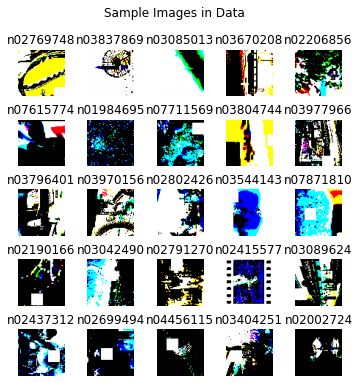

In [8]:
plot_sample_images(train_loader, classes, ncols=5, nrows=5, fig_size=(6,6))

# Train Model

## Model Arch

In [10]:
model =  ResNet18(num_classes=len(classes)).to(device)
print(get_model_summary(model, input_size=(3,64,64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

## LR Finder

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-04, momentum=0.9) 

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.84E-02


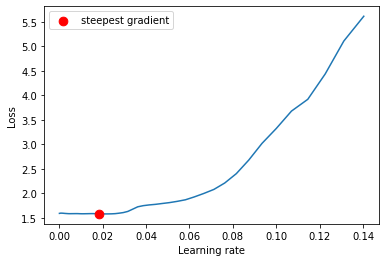

In [12]:
suggested_lr = get_lr_rates(model,criterion, optimizer, train_loader=train_loader, device=device, end_lr=1, step_mode="exp",val_loader=val_loader ,plot=True)

## Train the model

In [13]:
suggested_lr

0.01839525795803971

In [10]:
suggested_lr = 0.01839525795803971

In [9]:
model_path = '/gdrive/My Drive/session11_model.pth'
model = ResNet18(200)
model.load_state_dict(torch.load(model_path))
model = model.to(device)

In [11]:
EPOCHS = 30
MAX_AT_EPOCH = 10

train_losses, train_acc, test_losses, test_acc, lrs = [], [], [], [], []
best_test_acc = 0
model_path = '/gdrive/My Drive/session11_model.pth'

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=suggested_lr, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2,)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=200)
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=suggested_lr*2, steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [ ]:
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    # train
    train_epoch_acc, train_epoch_loss = train(model, device, train_loader, optimizer, criterion, l2_decay=5e-3, scheduler=None)
    train_losses.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # test
    test_epoch_acc, test_epoch_loss = validate(model, device, val_loader, criterion)
    test_losses.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

    scheduler.step(test_epoch_loss)

    # remember best accuracy and save the model
    is_best = test_epoch_acc > best_test_acc
    best_test_acc = max(test_epoch_acc, best_test_acc)

    if is_best:
        print('Saving Model for accuracy: ', test_epoch_acc)
        torch.save(model.state_dict(), model_path)

  0%|          | 0/137 [00:00<?, ?it/s]

EPOCH: 1


Loss=4.178772926330566 Batch_id=136 Accuracy=43.57: 100%|██████████| 137/137 [05:30<00:00,  2.41s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 10167/100000 (10.17%)

Saving Model for accuracy:  10.167
EPOCH: 2


Loss=4.192875385284424 Batch_id=136 Accuracy=44.13: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 10427/100000 (10.43%)

Saving Model for accuracy:  10.427
EPOCH: 3


Loss=4.096367835998535 Batch_id=136 Accuracy=45.44: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 9555/100000 (9.55%)

EPOCH: 4


Loss=4.051358222961426 Batch_id=136 Accuracy=46.12: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 10489/100000 (10.49%)

Saving Model for accuracy:  10.489
EPOCH: 5


Loss=3.7502810955047607 Batch_id=136 Accuracy=46.93: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 11400/100000 (11.40%)

Saving Model for accuracy:  11.4
EPOCH: 6


Loss=3.832611560821533 Batch_id=136 Accuracy=47.69: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 11505/100000 (11.51%)

Saving Model for accuracy:  11.505
EPOCH: 7


Loss=3.9280567169189453 Batch_id=136 Accuracy=47.84: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 10665/100000 (10.66%)

EPOCH: 8


Loss=3.921821355819702 Batch_id=136 Accuracy=49.02: 100%|██████████| 137/137 [05:32<00:00,  2.43s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 11132/100000 (11.13%)

EPOCH: 9


Loss=3.8015148639678955 Batch_id=136 Accuracy=49.31: 100%|██████████| 137/137 [05:32<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 11151/100000 (11.15%)

EPOCH: 10


Loss=3.75302791595459 Batch_id=136 Accuracy=49.53: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 11088/100000 (11.09%)

EPOCH: 11


Loss=3.7378811836242676 Batch_id=136 Accuracy=50.28: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 10801/100000 (10.80%)

EPOCH: 12


Loss=3.7408061027526855 Batch_id=136 Accuracy=51.21: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 10524/100000 (10.52%)

EPOCH: 13


Loss=3.704589366912842 Batch_id=136 Accuracy=51.62: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 11323/100000 (11.32%)

EPOCH: 14


Loss=3.6396491527557373 Batch_id=136 Accuracy=52.10: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 10754/100000 (10.75%)

EPOCH: 15


Loss=3.618889093399048 Batch_id=136 Accuracy=52.90: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 10568/100000 (10.57%)

EPOCH: 16


Loss=3.431317090988159 Batch_id=136 Accuracy=53.04: 100%|██████████| 137/137 [05:30<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 11212/100000 (11.21%)

EPOCH: 17


Loss=3.470663070678711 Batch_id=136 Accuracy=53.54: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 10757/100000 (10.76%)

EPOCH: 18


Loss=3.087820529937744 Batch_id=136 Accuracy=60.86: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 14678/100000 (14.68%)

Saving Model for accuracy:  14.678
EPOCH: 19


Loss=3.066209316253662 Batch_id=136 Accuracy=62.56: 100%|██████████| 137/137 [05:31<00:00,  2.42s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 14656/100000 (14.66%)

EPOCH: 20


Loss=3.065333366394043 Batch_id=136 Accuracy=63.64: 100%|██████████| 137/137 [05:30<00:00,  2.41s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 14760/100000 (14.76%)

Saving Model for accuracy:  14.76
EPOCH: 21


Loss=2.8963441848754883 Batch_id=136 Accuracy=64.26: 100%|██████████| 137/137 [05:30<00:00,  2.41s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 14692/100000 (14.69%)

EPOCH: 22


Loss=3.010909080505371 Batch_id=136 Accuracy=64.73: 100%|██████████| 137/137 [05:30<00:00,  2.41s/it]
  0%|          | 0/137 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 14688/100000 (14.69%)

EPOCH: 23


Loss=3.0927765369415283 Batch_id=14 Accuracy=65.76:  10%|█         | 14/137 [00:36<04:56,  2.41s/it]

In [ ]:
mfor epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    # train
    train_epoch_acc, train_epoch_loss = train(model, device, train_loader, optimizer, criterion, l2_decay=5e-3, scheduler=scheduler)
    train_losses.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # test
    test_epoch_acc, test_epoch_loss = validate(model, device, val_loader, criterion)
    test_losses.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

    #scheduler.step(test_epoch_loss)

    # remember best accuracy and save the model
    is_best = test_epoch_acc > best_test_acc
    best_test_acc = max(test_epoch_acc, best_test_acc)

    if is_best:
        print('Saving Model for accuracy: ', test_epoch_acc)
        torch.save(model.state_dict(), model_path)

In [15]:
print('BEST TEST ACCURACY:{}%'.format(max(test_acc)))

BEST TEST ACCURACY:12.969%


In [ ]:
 plt.plot(lrs)

# View Model Results

In [ ]:
plot_results(train_losses,train_acc,test_losses,test_acc)

In [13]:
#load the best model from path
resnet18_model = ResNet18(200)
resnet18_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
msx_images,msx_labels,msx_predictions = get_image_predictions(model.to('cpu'), test_loader,misclassified = True, count=25)

In [ ]:
show_images_predictions(msx_images,msx_labels,msx_predictions,classes,nrow=1, ncol=4,fig_size=(20,20))

# GradCam

In [ ]:
images = visualize_gradcam(model,msx_images, mean, std)

In [ ]:
image_grid = make_grid(torch.cat(images,), nrow=5)
save_image(image_grid, 'grad_cam.jpg')

img = PIL.Image.open('grad_cam.jpg')

img.resize((1000, 25*200))